# Mobile Games A/B Testing with Cookie Cats

## 1. Of cats and cookies

In [1]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
print(df.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In [2]:
df['userid'].count()

90189

The data is from 90,189 players that installed the game while the AB-test was running.

## 2. The AB-test data

The variables are:

userid - a unique number that identifies each player.

version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

sum_gamerounds - the number of game rounds played by the player during the first 14 days after installation.

retention_1 - did the player come back and play 1 day after installing?

retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to gate_30 or gate_40. The first step is to see if there are roughly the same number of players in each AB group.

In [3]:
# Counting the number of players in each AB group.
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


There is roughly the same number of players in each group.

## 3. The distribution of game rounds

This analysis is focused on how the gate placement affects player retention, but let's plot the distribution of the number of game rounds players played during their first week playing the game.

Text(0, 0.5, 'userid')

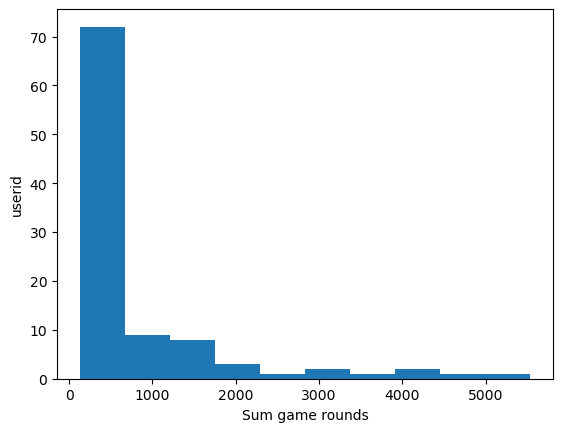

In [4]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x='sum_gamerounds', y='userid', kind='hist')
ax.set_xlabel("Sum game rounds")
ax.set_ylabel("userid")

Some players install the game but never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get hooked on the plot above.

## 4. Overall 1-day retention

A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that come back and play the game one day after they have installed it. The higher the 1-day retention is, the easier it is to retain players and build a large player base.

As a first step, let's look at what 1-day retention is overall.

In [5]:
# The % of users that came back the day after they installed
df['retention_1'].sum()

40153

A little less than half of the players come back one day after installing the game. Now, how does 1-day retention differ between the two AB groups?

In [6]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].sum()

version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64

There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control, level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact.

## 5. Should we be confident in the difference?

While there can be seen a difference in the data, how certain is that a gate at level 40 will be worse in the future?

Bootstrapping can be used for the certainty of these retention numbers Samples will be repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

<Axes: ylabel='Density'>

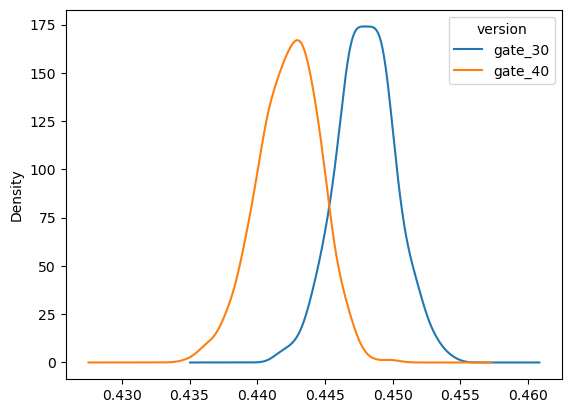

In [7]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='kde')

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. 

The number of bootstrap replication to 500 to keep the calculations quick. In "production" we would likely increase this to a much larger number, say, 10,000.

## 6. Zooming in on the difference

Let's see the difference in 1-day retention.

Text(0.5, 0, 'Difference between gate 30 and 40')

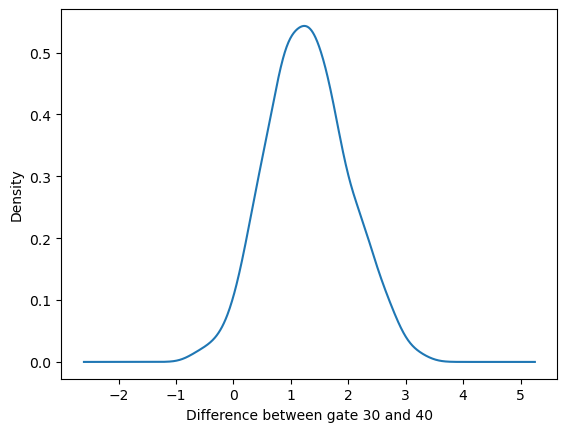

In [8]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (
    (boot_1d['gate_30'] - boot_1d['gate_40']) / 
    boot_1d['gate_40'] * 100)

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='kde')
ax.set_xlabel('Difference between gate 30 and 40')

The most likely % difference is around 1% - 2% and most of the distribution is above 0%, in favor of a gate at level 30 From this chart

## 7. The probability of a difference

What is the probability that the difference is above 0%?

In [9]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30.
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Pretty printing the probability
'{:.1%}'.format(prob)

'97.6%'

There is a high probability, 96.2 % that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, most likely, most players have not reached level 30 yet. This means that many players were not been affected by the gate, even if it was as early as level 30.

## 8. 7-day retention by AB-group

After having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. What percentage of the people who installed the game also showed up a week later to play the game again?

In [10]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].sum()

version
gate_30    8502
gate_40    8279
Name: retention_7, dtype: int64

7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. The overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

## 9. Bootstrapping the difference again

As before, the bootstrap analysis was used to figure out the difference between the AB groups.

'97.6%'

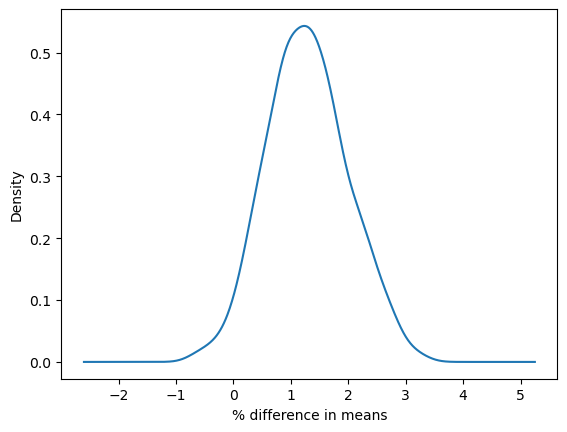

In [11]:
# Creating an list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
        
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_1d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (
    (boot_7d['gate_30'] - boot_7d['gate_40']) / 
    boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Pretty printing the probability
'{:.1%}'.format(prob)

## 10. The conclusion

There is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40 from the bootstrap result. The conclusion from this work is that to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. Other metrics should be looked at like the number of game rounds played or how many in-game purchases are made by the two AB groups. However, retention is one of the most important metrics. If the game does not retain its player base, it does not matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.